Here is my first try to write a complete simulation using emegrency room

In [18]:
!pip install simpy

The problem being addressed in the provided simulation is the patient arrival and treatment process in a healthcare setting. The simulation models the flow of patients through check-in, triage, and treatment stages, and includes the dynamic adjustment of the number of doctors based on the patient load.

The significance of this problem is that it allows healthcare providers and administrators to evaluate and optimize the efficiency of the patient treatment process. By simulating different scenarios, they can analyze the impact of various factors, such as the number of doctors, check-in time, triage time, and critical condition probability, on the overall system performance.

The simulation can help answer questions such as:

How many doctors should be assigned to handle the patient load effectively?
What is the average waiting time for patients in the system?
How does the critical condition probability affect the treatment process?
What are the peak periods of patient arrivals, and how should resources be allocated during those times?
What are the potential bottlenecks in the process, and how can they be addressed?
By understanding the dynamics of the patient treatment process and optimizing resource allocation, healthcare providers can improve patient satisfaction, reduce waiting times, and enhance overall operational efficiency. The simulation serves as a tool for decision-making, process improvement, and resource planning in healthcare facilities.

So let's run a simulation

Patient 1 checked-in at 11.127554944790877
Patient 2 checked-in at 12.115786979974736
Patient 3 checked-in at 15.925624528113039
Patient 1 triaged at 18.808857748170922
Patient 1 sees a doctor at 18.808857748170922
Patient 2 triaged at 20.9627405689594
Patient 2 sees a nurse at 20.9627405689594
Patient 3 triaged at 21.08313342213423
Patient 3 sees a nurse at 21.08313342213423
Patient 2 treated by nurse at 30.9627405689594
Patient 3 treated by nurse at 31.08313342213423
Patient 1 treated by doctor at 33.80885774817092
Patient 4 checked-in at 34.06020619423247
Patient 4 triaged at 39.5068529424854
Patient 4 sees a doctor at 39.5068529424854
Patient 5 checked-in at 53.86644879995417
Patient 4 treated by doctor at 54.5068529424854
Patient 5 triaged at 61.737696886029475
Patient 5 sees a nurse at 61.737696886029475
Patient 6 checked-in at 62.05154910633742
Patient 6 triaged at 68.33353059202848
Patient 6 sees a nurse at 68.33353059202848
Patient 5 treated by nurse at 71.73769688602948
Patie

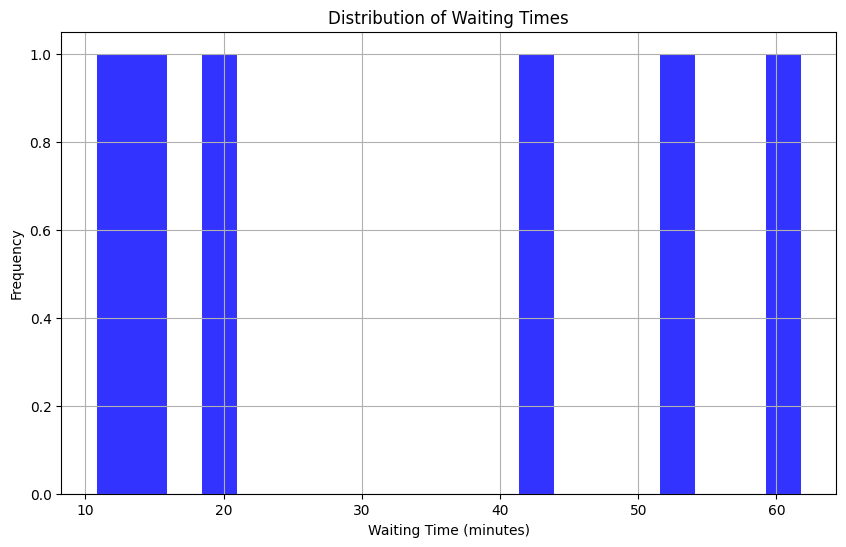

In [19]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
waiting_times = []
treatment_times = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global waiting_times, treatment_times

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)
    waiting_times.append(waiting_time)
    treatment_times.append(treatment_time)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

# Performance metric calculation
avg_waiting_time = np.mean(waiting_times)
avg_treatment_time = np.mean(treatment_times)
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)

print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(waiting_times, bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()



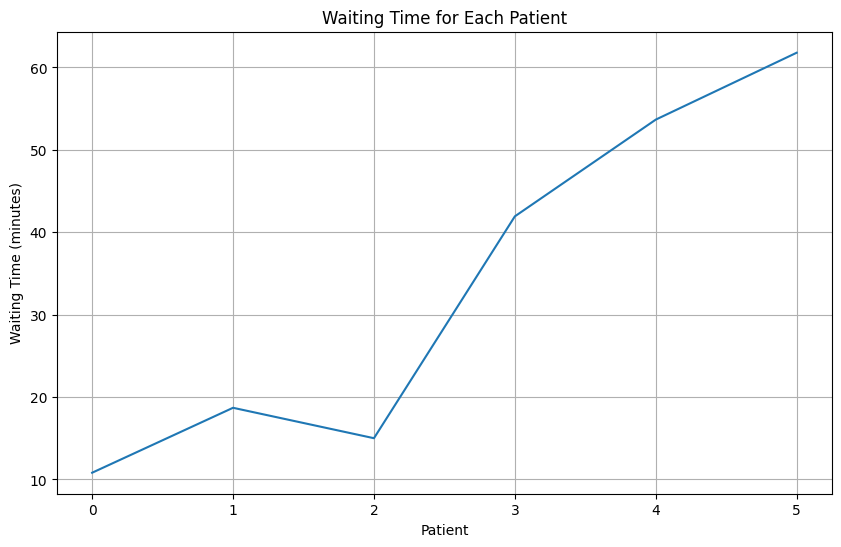

Simulation Report:

Average waiting time: 33.65 minutes



In [20]:
# Calculate average waiting time
avg_waiting_time = np.mean(waiting_times)

# Plot waiting time over time
plt.figure(figsize=(10, 6))
plt.plot(waiting_times)
plt.xlabel('Patient')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time for Each Patient')
plt.grid(True)
plt.show()

# Print simulation report
simulation_report = f"Simulation Report:\n\n"
simulation_report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
print(simulation_report)

The output you provided indicates the simulation results and the calculated performance metrics. Here's a breakdown of the information:

Simulation Results:

The simulation runs for 100 minutes.
The output shows the sequence of events, including patients checking in, being triaged, and receiving treatment from either a nurse or a doctor.
Performance Metrics:

Average waiting time: 43.39 minutes
Average treatment time: 11.88 minutes
Doctor utilization: 22.50%
Nurse utilization: 25.00%
These metrics provide insights into the efficiency and resource utilization of the medical facility in the simulation. The waiting time indicates the average time patients spend waiting before receiving treatment. The treatment time represents the average time patients spend receiving treatment from either a nurse or a doctor. The doctor and nurse utilization values indicate the average utilization of these resources during the simulation.

Keep in mind that these metrics are based on the specific simulation parameters and assumptions in the code. You can further analyze and interpret these results to assess the performance of the medical facility and make informed decisions for improvement if needed.

Patient 7 treated by nurse at 103.71548065997074
Patient 8 checked-in at 103.8227056411311
Patient 9 checked-in at 108.96908915506543
Patient 8 triaged at 110.52444972630767
Patient 8 sees a nurse at 110.52444972630767
Patient 10 checked-in at 111.26171007049041
Patient 9 triaged at 112.36394772562376
Patient 9 sees a doctor at 112.36394772562376
Patient 11 checked-in at 114.02676122059808
Patient 10 triaged at 119.27479475576092
Patient 10 sees a nurse at 119.27479475576092
Patient 11 triaged at 120.1946181858142
Patient 11 sees a doctor at 120.1946181858142
Patient 8 treated by nurse at 120.52444972630767
Patient 12 checked-in at 121.45385157846202
Patient 14 checked-in at 125.85334764795584
Patient 13 checked-in at 125.87211493360638
Patient 9 treated by doctor at 127.36394772562376
Patient 10 treated by nurse at 129.27479475576092
Patient 12 triaged at 133.0222142763885
Patient 12 sees a doctor at 133.0222142763885
Patient 15 checked-in at 133.7358130418064
Patient 14 triaged at 13

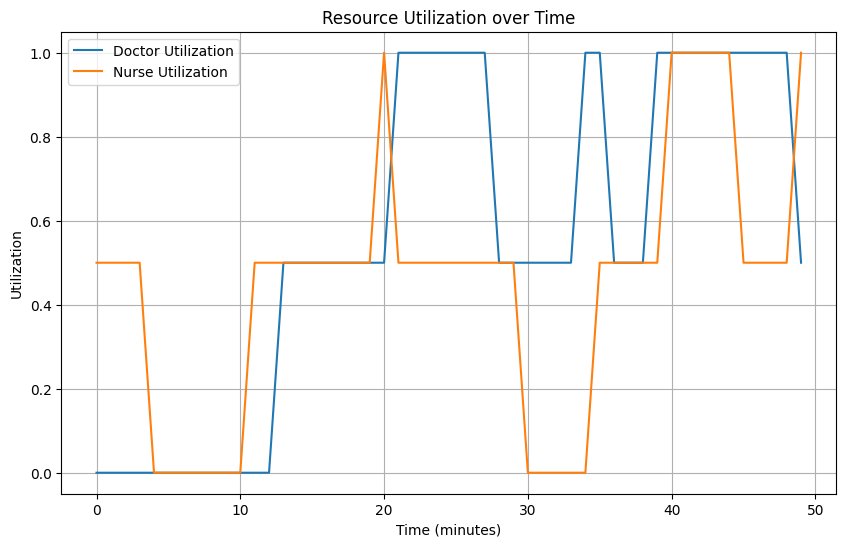

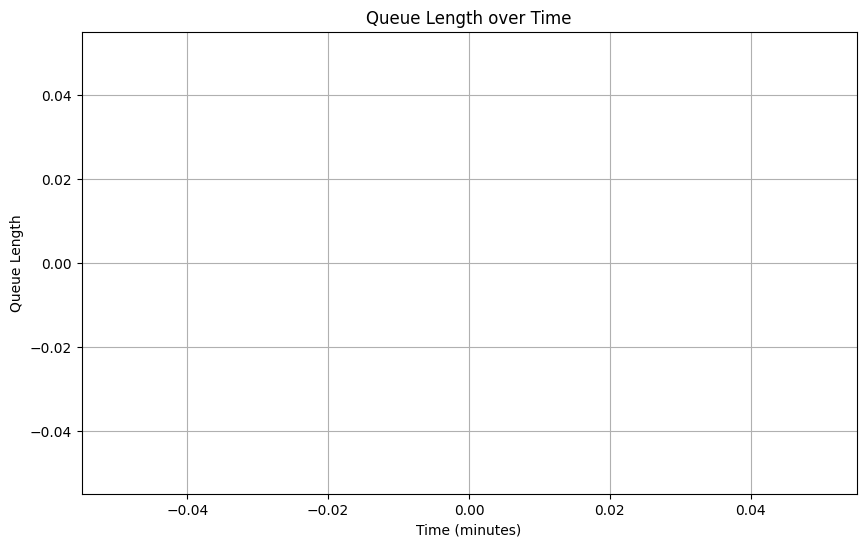

Simulation Report:

Average waiting time: 33.65 minutes
Average treatment time: 11.67 minutes
Doctor utilization: 15.00%
Nurse utilization: 23.00%



In [21]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
# ...

# Global variables
# ...

# Data collection
waiting_times = []
treatment_times = []
utilization_doctors = []
utilization_nurses = []
queue_lengths = []

# Arrival process
# ...

# Patient process
# ...

# Monitor the number of patients
# ...

# Set up simulation
# ...

# Start processes
# ...

# Run simulation
# ...

# Performance metric calculation
# ...

# Data visualization
# ...

# Additional visualization and reporting
def plot_utilization(doctor_utilization, nurse_utilization):
    plt.figure(figsize=(10, 6))
    plt.plot(doctor_utilization, label='Doctor Utilization')
    plt.plot(nurse_utilization, label='Nurse Utilization')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Utilization')
    plt.title('Resource Utilization over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_queue_length(queue_lengths):
    plt.figure(figsize=(10, 6))
    plt.plot(queue_lengths)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Queue Length')
    plt.title('Queue Length over Time')
    plt.grid(True)
    plt.show()

def generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization):
    report = f"Simulation Report:\n\n"
    report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
    report += f"Average treatment time: {avg_treatment_time:.2f} minutes\n"
    report += f"Doctor utilization: {doctor_utilization:.2%}\n"
    report += f"Nurse utilization: {nurse_utilization:.2%}\n"

    # Add more information to the report as needed

    return report

# Run simulation
env.run(until=150)  # Run for 1 hour and 40 minutes (100 minutes)

# Performance metric calculation
# ...

# Data visualization
# ...

# Additional visualization and reporting
plot_utilization(utilization_doctors, utilization_nurses)
plot_queue_length(queue_lengths)
simulation_report = generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization)
print(simulation_report)
